# Exercise: Recognizing Textual Entailment

In this exercise, we are going to implement some of the models discussed in the Deep Learning for Natural Language Processing chapter. Specifically, we are going to implement an RTE system using TensorFlow. Instead of running this on a large corpus like SNLI, we are working on a very small corpus for implementation purposes. This is a common practice as in early stages of development we will likely encounter bugs in our cope and compile and run-time errors for which we do not need to train on a lot of data. It is generally a good idea to first test whether our model can overfit a tiny debug corpus.

In [3]:
import numpy as np

# examples from SNLI training corpus, 2=entailment, 1=neutral, 0=contradiction
# premise, hypothesis, label
data = [
    ("Children smiling and waving at camera", "They are smiling at their parents", 1),
    ("A boy is jumping on skateboard in the middle of a red bridge.", "The boy does a skateboarding trick.", 2),
    ("A boy is jumping on skateboard in the middle of a red bridge.", "The boy skates down the sidewalk.", 0),
    ("A person on a horse jumps over a broken down airplane.", "A person is outdoors, on a horse.", 2),    
    ("A woman in a green jacket and hood over her head looking towards a valley.", "The woman is cold.", 1),
    ("A couple playing with a little boy on the beach.", "A couple watch a little girl play by herself on the beach.", 0)
]

def data2np(data, PAD=0):
    """Transforms data into a list of numpy tensors."""
    premises = []; premise_lengths = []
    hypotheses = []; hypothesis_lengths = []
    labels = []    
    for premise, hypothesis, label in data:
        premise_tokenized = premise.split(" ")
        premises.append(premise_tokenized)
        premise_lengths.append(len(premise_tokenized))
        hypotheses_tokenized = hypothesis.split(" ")
        hypotheses.append(hypotheses_tokenized)
        hypothesis_lengths.append(len(hypotheses_tokenized))
        labels.append(label)
    vocab = {"<PAD>": PAD}
    premises_np = np.full([len(data), np.max(premise_lengths)], PAD)
    hypotheses_np = np.full([len(data), np.max(hypothesis_lengths)], PAD)    
    for k, seqs in enumerate([premises, hypotheses]):
        for i, seq in enumerate(seqs):
            for j, word in enumerate(seq):
                if word not in vocab:
                    vocab[word] = len(vocab)
                seq[j] = vocab[word] 
            if k == 0:
                premises_np[i, 0:premise_lengths[i]] = seq
            else:
                hypotheses_np[i, 0:hypothesis_lengths[i]] = seq
    return premises_np, premise_lengths, hypotheses_np, hypothesis_lengths, labels, vocab

premises_np, premise_lengths, hypotheses_np, hypothesis_lengths, labels, vocab = data2np(data)

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full([6, 15], 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full([6, 12], 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


Epoch: 0 Loss: 6.53497


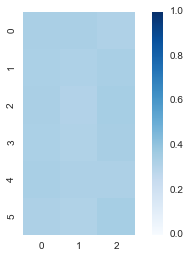

Epoch: 1 Loss: 6.07495


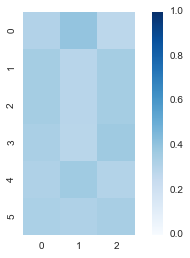

Epoch: 2 Loss: 5.07668


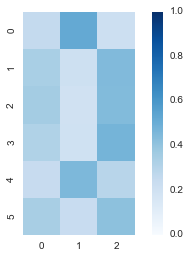

Epoch: 3 Loss: 3.86799


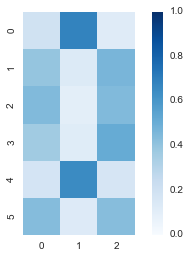

Epoch: 4 Loss: 2.91219


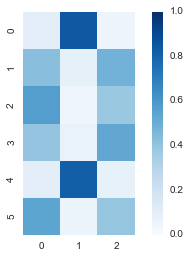

Epoch: 5 Loss: 1.97814


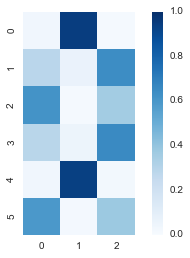

Epoch: 6 Loss: 1.07354


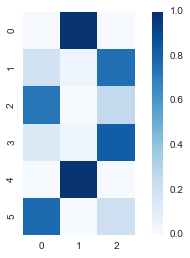

Epoch: 7 Loss: 0.744045


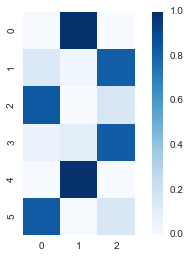

Epoch: 8 Loss: 0.767947


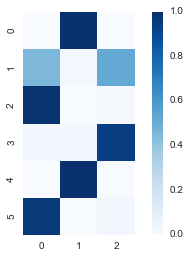

Epoch: 9 Loss: 0.483709


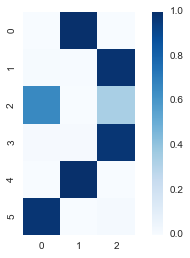

In [4]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

with tf.Graph().as_default():
    ## Placeholders
    # [batch_size x max_premise_length]
    premises_pl = tf.placeholder(tf.int64, [None, None], "premises")
    # [batch_size]
    premise_lengths_pl = tf.placeholder(tf.int64, [None], "premise_lengths")
    # [batch_size x max_hypothesis_length]
    hypotheses_pl = tf.placeholder(tf.int64, [None, None], "hypotheses")
    # [batch_size]
    hypothesis_lengths_pl = tf.placeholder(tf.int64, [None], "hypothesis_lengths")
    # [batch_size]
    labels_pl = tf.placeholder(tf.int64, [None], "labels")

    ## Model
    input_size = 2
    hidden_size = 5
    target_size = 3
    vocab_size = len(vocab)

    embeddings = tf.get_variable("W", [vocab_size, input_size])

    # [batch_size x max_premise_length x input_size]
    premises_embedded = tf.nn.embedding_lookup(embeddings, premises_pl)
    # [batch_size x max_hypothesis_length x input_size]
    hypotheses_embedded = tf.nn.embedding_lookup(embeddings, hypotheses_pl)

    with tf.variable_scope("encoder") as varscope:
        cell = tf.nn.rnn_cell.LSTMCell(hidden_size, state_is_tuple=True)
        _, premise_final_state = \
            tf.nn.dynamic_rnn(cell, premises_embedded, sequence_length=premise_lengths_pl, dtype=tf.float32)    
        # [batch_size x hidden_size]
        premises_h = premise_final_state.h
        varscope.reuse_variables()  # using the same encoder for premises and hypotheses
        _, hypothesis_final_state = \
            tf.nn.dynamic_rnn(cell, hypotheses_embedded, sequence_length=hypothesis_lengths_pl, dtype=tf.float32)  
        # [batch_size x hidden_size]
        hypotheses_h = hypothesis_final_state.h
         
    # [batch_size x 2*hidden_size]
    pair_representation = tf.concat(1, [premises_h, hypotheses_h])
        
    # [batch_size x target_size]
    logits = tf.contrib.layers.linear(pair_representation, target_size)
        
    probability = tf.nn.softmax(logits)
    
    ## Training Loss
    loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels_pl))
            
    ## Optimizer
    optim = tf.train.AdamOptimizer(0.1)
    optim_op = optim.minimize(loss)
        
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        feed_dict = {
            premises_pl: premises_np,
            premise_lengths_pl: premise_lengths,
            hypotheses_pl: hypotheses_np,
            hypothesis_lengths_pl: hypothesis_lengths,
            labels_pl: labels
        }
        
        for i in range(10):
            _, current_loss, current_probabilities = sess.run([optim_op, loss, probability], feed_dict)
            print("Epoch:", i, "Loss:", current_loss)
            sns.heatmap(current_probabilities, vmin=0.0, vmax=1.0, square=True, cmap="Blues") 
            plt.show()

# Task
Extend the above model, for instance, by:
  - Multi-layer instead of single-layer perceptron for prediction
  - Bucketing
  - Batching (instead of passing the entire dataset to the model)
    - Make sure to draw random batches from the data
  - Stacked RNNs (see `tf.nn.rnn_cell.MultiRNNCell`)
  - Dropout on the input and output embeddings (see `tf.nn.dropout`)
  - L2 regularization (see `tf.nn.l2_loss`)
  - Gradient clipping (see `tf.clip_by_value` or `tf.clip_by_norm`)
  - Conditional encoding
  - Bi-directional RNNs
  - Attention
  - Word-by-word attention
  - Larger portion of SNLI corpus (see http://nlp.stanford.edu/projects/snli/)
  - Pre-trained word representations
  - Better tokenization
  - Early stopping
  - Hyper-parameter optimization (e.g. random search)
    - Initial learning rate
    - Dropout probability
    - Input and output size
    - L2 regularization
    - Gradient clipping value
    - Batch size
    - ...
  - Any ideas from papers on nlp.stanford.edu/projects/snli/